In [1]:
import numpy as np
import scipy as sp
import time
from tqdm import tqdm

In [2]:
import env
import parallel_smd
import qvi
import smd

In [3]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc_file_defaults()

In [5]:
def experiment(MDP, eps, n_samples, n_mixing, N_psmd, N_smd, t_mix=None):
    np.random.seed(723)
    empiricalMDP = env.EmpiricalMDP(MDP, n_samples)
    
    if t_mix is None:
        t_mix = MDP.mixing_time(n_mixing)
    print('Mixing time : {}'.format(t_mix))
    
    start_time = time.time()
    v_star = MDP.amdp_solve()
    print('Time for solving AMDP: {} sec.'.format(time.time() - start_time))
    print(v_star)
    
    np.random.seed(723)
    policies_psmd, times_psmd = parallel_smd.parallel_SMD(
        eps, N_psmd, MDP, empiricalMDP, t_mix, 10000,
        updates=True, warmup=True)
    
    if N_smd is not None:
        np.random.seed(723)
        policies_smd, times_smd = smd.SMD(eps, N_smd, MDP, t_mix, 10000)
    else:
        times_smd = []
    
    delta_psmd = []
    for pi in tqdm(policies_psmd):
        v_pi = MDP.amdp_value(pi)
        delta_psmd.append(v_star - v_pi)

    delta_smd = []
    if N_smd is not None:
        for pi in tqdm(policies_smd):
            v_pi = MDP.amdp_value(pi)
            delta_smd.append(v_star - v_pi)
        
        
    return delta_psmd, delta_smd, times_psmd, times_smd

# Experiment #3: Access-Control Queueing task

In [6]:
access_control = env.AccessControl(10, np.array([0.125, 0.25, 0.5, 1]), 0.06)

In [7]:
delta_psmd, delta_smd, times_psmd, times_smd = experiment(
    access_control, eps=1e-2, n_samples=10000, n_mixing=1000, N_psmd=10000000, N_smd=10000000)

  0%|          | 1295/10000000 [00:00<12:52, 12941.93it/s]

Mixing time : 44
Time for solving AMDP: 0.04968738555908203 sec.
0.3341490307719515


100%|██████████| 1000/1000 [00:02<00:00, 415.44it/s]


In [12]:
fig = plt.figure(figsize = (15,7), dpi=1200)
ax = fig.add_subplot()

xs = np.arange(10001)
k = 0
to = 1000

ax.plot(10000 * np.arange(k+1, to+1), delta_smd[k:to],  linewidth=3, label='Stochastic Mirror Descent [Jin et al.]')
ax.plot(10000 * np.arange(k+1, to+1), delta_psmd[k:to], linewidth=3, label='Parallel Stochastic Mirror Descent [This paper]')

plt.legend(loc="upper right", prop={'size': 20}, frameon=True)

plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
plt.xlabel(r'#iterations', fontsize=30)
plt.ylabel(r'$\bar v^* - \bar v^\pi$', fontsize=25)

plt.yticks(fontsize=20)
plt.yscale('log')

plt.xticks(fontsize=20)

ax.grid()
ax.grid(which='minor',  color = 'k',linestyle = ':')
ax.yaxis.set_minor_formatter(plt.LogFormatter(minor_thresholds=(10,2)))

In [13]:
delta_psmd2, delta_smd2, times_psmd2, times_smd2 = experiment(
    access_control, eps=1e-2, n_samples=500, n_mixing=1000, N_psmd=10000000, N_smd=10000000)

  0%|          | 1035/10000000 [00:00<16:06, 10349.84it/s]

Mixing time : 44
Time for solving AMDP: 0.07281279563903809 sec.
0.3341490307719515


100%|██████████| 1000/1000 [00:02<00:00, 399.38it/s]


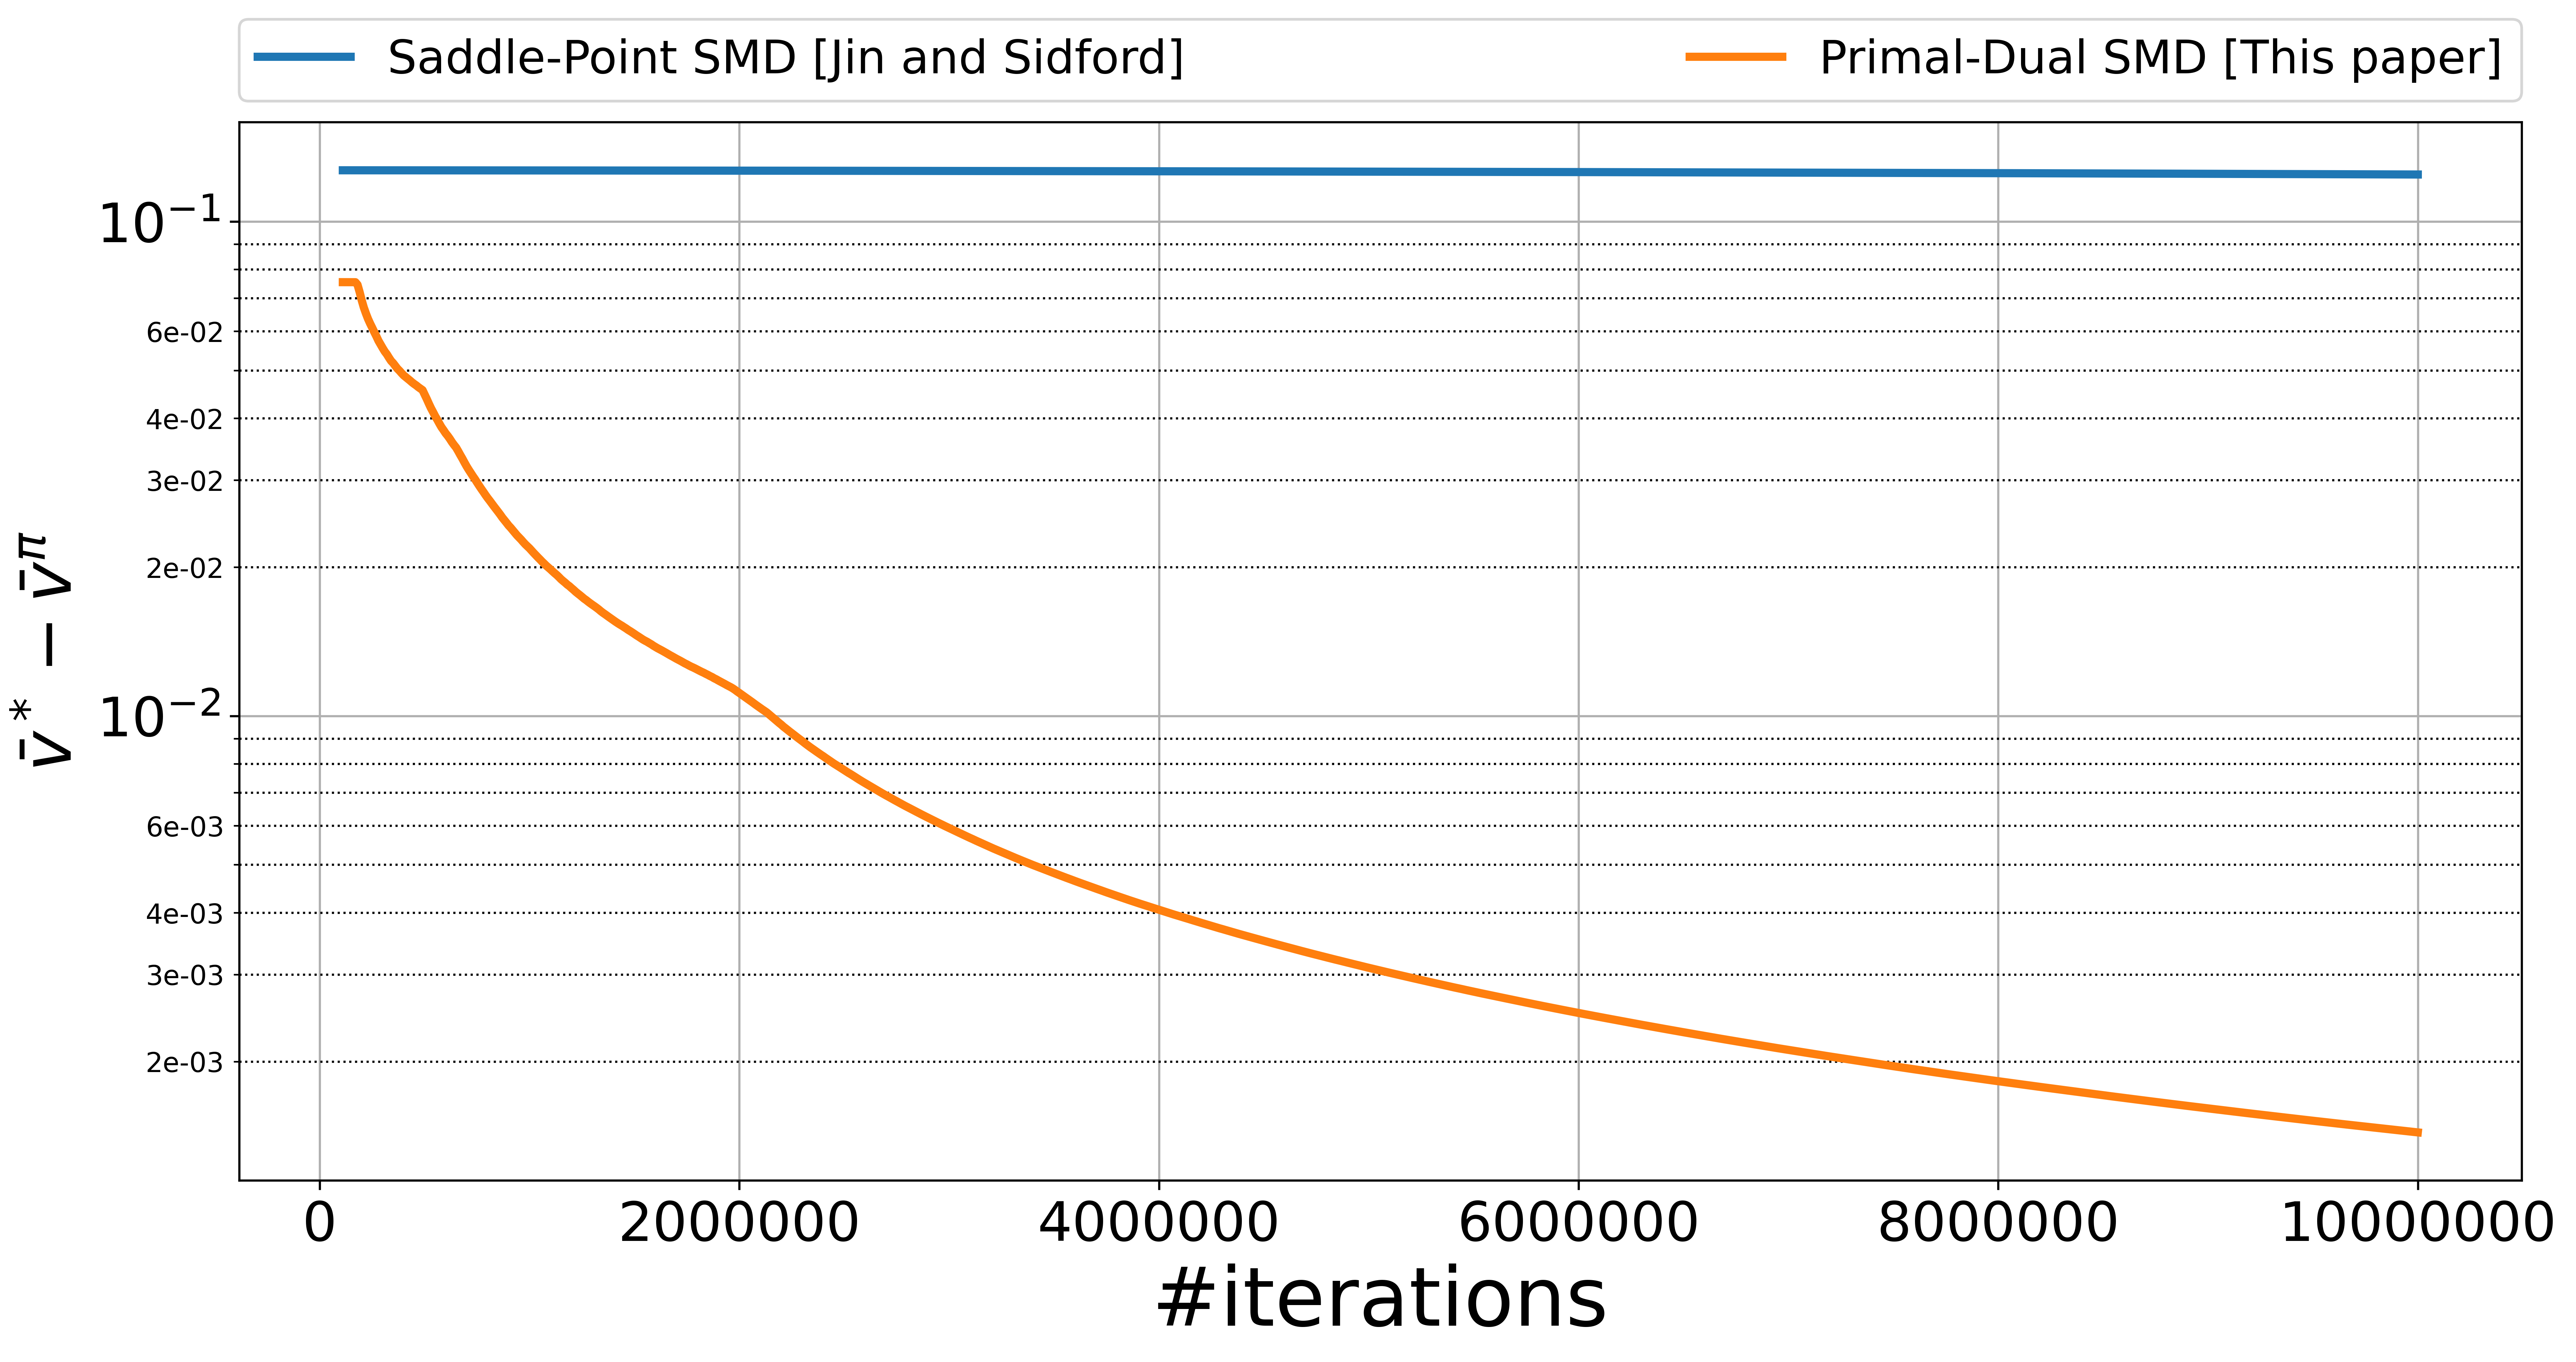

In [19]:
fig = plt.figure(figsize = (15,7), dpi=600)
ax = fig.add_subplot()

xs = np.arange(10001)
k = 10
to = 1000

ax.plot(10000 * np.arange(k+1, to+1), delta_smd2[k:to],  linewidth=3, label='Saddle-Point SMD [Jin and Sidford]')
ax.plot(10000 * np.arange(k+1, to+1), delta_psmd2[k:to], linewidth=3, label='Primal-Dual SMD [This paper]')

plt.legend(loc="lower left", bbox_to_anchor=(0., 1.02, 1., .102), prop={'size': 17}, ncol=2, mode="expand", borderaxespad=0., frameon=True)

plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
plt.xlabel(r'#iterations', fontsize=30)
plt.ylabel(r'$\bar v^* - \bar v^\pi$', fontsize=25)

plt.yticks(fontsize=20)
plt.yscale('log')

plt.xticks(fontsize=20)

ax.grid()
ax.grid(which='minor', color = 'k',linestyle = ':')
ax.yaxis.set_minor_formatter(plt.LogFormatter(minor_thresholds=(10,2)))